# Efficient Python methods


<div class="questions">  
### Questions

- "Which method for acceleration should I choose?"
- "How do I utilise traditional python approaches to multi cpu and nodes"
</div>

<div class="objectives">  
### Objectives

- "Learn simples methods to profile your code"
- "See how numpy and pandas use Vectorising to improve performance for some data"
- "Use MPI to communicate between workers"
- "Discover python multiprocessing and mpi execution"
</div>

In this session we will show you a few of the basic tools that we can use in Python to make our code go faster. There is no perfect method for optimising code. Efficiency gains depend on what your end goal is, what libraries are available, what method or approach you want to take when writing algorithms, what your data is like, what hardware you have. Hopefully these notes will allow you to think about your problems from different perspectives to give you the best opportunity to make your development and execution as efficient as possible.

## Acceleration, Parallelisation, Vectorising, Threading, make-Python-go-fast 

We will cover a few of the ways that you can potentially speed up Python. As we will learn there are multitudes of methods to make Python code more efficient, and also different implementations of libraries, tools, techniques that can all be utilised depending on how your code and/or data is organised. This is a rich and evolving ecosystem and there is no one perfect way to implement efficiencies.

Some key words that might come up:

* Vectorisation
* MPI message parsing interface
* CPU, core, node, thread, process, worker, job, task
* Parallelisation
* Python decorators and functional programming.

<br>

### What does *parallel* mean?
Separate workers or processes acting in an independent or semi-dependent manner. Independent processes ship data, program files and libraries to an isolated ecosystem where computation is performed. In this case communication between workers can be achieved. Contrastingly there are also shared memory set ups where multiple computational resources are pooled together to work on the same data. 

Generally speaking, parallel workflows fit different categories of data handling which can make you think about how to write your code and what approaches to take.

#### Embarrassingly parallel:
Requires no communication between processors. Utilise shared memory spaces. For example:

* Running same algorithm for a range of input parameters.
* Rendering video frames in computer animation.
* Open MP implementations.

#### Coarse/Fine-grained parallel:
Requires occasional or frequent communication between processors. Uses a small number of processes on large data. Fine grain uses a large number of small processes with very little communication. But can improves computationally bound problems. For example:

* Some examples are 
* Finite difference time-stepping on parallel grid.
* Finite element methods.
* Parallel tempering and MCMC.
* MPI implementations.

Traditional implementations of parallelism  are done on a low level. However, open source software has ***evolved*** dramatically over the last few years allowing more ***high level implementations and concise 'pythonic' syntax*** that wraps around low level tools. 

<br>

## Profiling your code

Before you get stuck into making things fast, it is important to find out what is exactly slow in your code. Is it a particular function running slow? Or are you calling a really fast function a million times? You can save yourself a lot development time by profiling your code to give you an idea for where efficiencies can be found. Try out Jupyter's ```%%timeit``` magic function.

In [1]:
%%timeit
import time
time.sleep(1)

1.01 s ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A neat little feature to check how fast some of your cells are running.
Now let's profile a simple Python script and then think about how we could make it faster.
Put this code in a script (save it as ```faster.py```):

In [2]:
#A test function to see how you can profile code for speedups

import time

def waithere():
	print("waiting for 1 second")
	time.sleep(1)

def add2(a=0,b=0):
	print("adding", a, "and", b)
	return(a+b)

def main():
	print("Hello, try timing some parts of this code!")
	waithere()	
	add2(4,7)
	add2(3,1)
    
if __name__=='__main__':
	main()

Hello, try timing some parts of this code!
waiting for 1 second
adding 4 and 7
adding 3 and 1


There are several ways to debug and profile Python, a very elegant and built in one is [cProfile](https://docs.python.org/3/library/profile.html)
It analyses your code as it executes. Run it with ```python -m cProfile faster.py```  and see the output of the script and the profiling:

```
Hello, try timing some parts of this code!
waiting for 1 second
adding 4 and 7
adding 3 and 1

12 function calls in 1.008 seconds

Ordered by: standard name

ncalls  tottime  percall  cumtime  percall filename:lineno(function)
1    0.000    0.000    1.008    1.008 faster.py:12(main)
1    0.000    0.000    1.008    1.008 faster.py:2(<module>)
1    0.000    0.000    1.002    1.002 faster.py:4(waithere)
2    0.000    0.000    0.005    0.003 faster.py:8(add2)
1    0.000    0.000    1.008    1.008 {built-in method builtins.exec}
4    0.007    0.002    0.007    0.002 {built-in method builtins.print}
1    1.001    1.001    1.001    1.001 {built-in method time.sleep}
1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
```

You can now interrogate your code and see where you should devote your time to improving it.

Special note on style: Developing python software in a ***modular*** manner assists with debugging and time profiling. This is a bit different to the sequential notebooks we have been creating. But re-writing certain snippets in self-contained functions can be a fun task.

## Exercise
Revisit some of the codes we have run previously. You can do this from a Jupyter Notebook by clicking ```File > Downlad as > Python (.py)```. You may need to comment-out some sections, espiecially where figures are displayed, to get them to run. Run it using **cProfile** and look at the results. Can you identify where improvements could be made?

<br>

## Loops and vectorising code with numpy and pandas

Your problem might be solved by using the fast way certain packages handle certain datatypes. 

Generally speaking, pandas and numpy libraries should be libraries you frequently use. They offer advantages in high performance computing including:
1. Efficient datastructures that under the hood are implemented in fast C code rather than python.
2. Promoting explicit use of datatype declarations - making memory management of data and functions working on this data, faster.
3. Elegant syntax promoting consice behaviour. 
4. Data structures come with common built in functions that are designed to be used in a vectorised way.

Lets explore this last point on vectorisation with an example. Take this nested for loop example:

In [3]:
#import packages
import numpy as np
import pandas as pd
import time 

#Create some fake data to work with
Samples = pd.DataFrame(np.random.randint(0,100,size=(100, 4)), columns=list('ABCD'))
Wells = pd.DataFrame(np.random.randint(0,100,size=(50, 1)), columns=list('A'))

#This could perhaps be the id of a well and the list of samples found in the well. 
#You want to match up the samples with some other list, 
#perhaps the samples from some larger database like PetDB.

#Create an emtpy dataframe to fill with the resulting matches
totalSlow=pd.DataFrame(columns=Samples.columns)
totalFast=pd.DataFrame(columns=Samples.columns)

In [4]:
#Now compare the nested for-loop method:

tic=time.time()
for index,samp in Samples.iterrows():
    for index2,well in Wells.iterrows():
        if well['A']==samp['A']:
            totalSlow=totalSlow.append(samp,ignore_index=True)
            
totalSlow=totalSlow.drop_duplicates()
toc=time.time()
print("Nested-loop Runtime:",toc-tic, "seconds")


Nested-loop Runtime: 0.4779984951019287 seconds


In [5]:
#Or the vectorised method:

tic=time.time()
totalFast=Samples[Samples['A'].isin(Wells.A.tolist())]
totalFast=totalSlow.drop_duplicates()
toc=time.time()
print("Vectorized Runtime:",toc-tic, "seconds")


Vectorized Runtime: 0.0019991397857666016 seconds


Which one is faster? Note the use of some really basic timing functions, these can help you understand the speed of your code.

## Python Multiprocessing

From within Python you may need a flexible way to manage computational resources. This is traditionally done with the ***multiprocessing*** library. 

With multiprocessing, Python creates new processes. A process here can be thought of as almost a completely different program, though technically they are usually defined as a collection of resources where the resources include memory, file handles and things like that. 

One way to think about it is that each ***process runs in its own Python interpreter***, and multiprocessing farms out parts of your program to run on each process.

### Some terminology - Processes, threads and shared memory
A ***process*** is a collection of resources including program files and memory, that operates as an independent entity. Since each process has a seperate memory space, it can operate independently from other processes. It cannot easily access shared data in other processes.

A ***thread*** is the unit of execution within a process. A process can have anywhere from just one thread to many threads. Threads are considered lightweight because they use far less resources than processes. Threads also share the same memory space so are not independent.

![SegmentLocal](./fig/process_v_thread.png "segment")

![SegmentLocal](./fig/process_threads_comparison.png "segment")

Back to python, the multiprocessing library was designed to break down the **Global Interpreter Lock (GIL)** that limits one thread to control the Python interpreter. 

In Python, the things that are occurring simultaneously are called by different names (thread, task, process). While they all fall under the definition of concurrency (multiple things happening anaologous to different trains of thought), only multiprocessing actually runs these trains of thought at literally the same time. We will only cover multiprocessing here which assists in CPU bound operations - but keep in mind other methods exist (threading), whose implementation tends to be more low level. 

## Simple multiprocessing example

Some basic concepts in the multiprocessing library are:
1. the ```Pool(processes)``` object creates a pool of processes. ```processes``` is the number of worker processes to use (i.e Python interpreters). If ```processes``` is ```None``` then the number returned by ```os.cpu_count()``` is used.
2. The ```map(function,list)``` attribute of this object uses the pool to map a defined function to a list/iterator object

To implement multiprocessing in its basic form. You can complete this exercise in a notebook or a script.



In [6]:
#Import the libraries we will need
import shapefile
import numpy as np
import matplotlib.pyplot as plt 
import multiprocessing
import time

#Check how many cpus are availble on your computer
multiprocessing.cpu_count()

#Read in the shapefile that we will use
sf = shapefile.Reader("../data/platepolygons/topology_platepolygons_0.00Ma.shp")
recs    = sf.records()
shapes  = sf.shapes()
fields  = sf.fields
Nshp    = len(shapes)
polygons=np.arange(Nshp)

Record #10: [0, 0.0, 'Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml', 'Global_EarthByte_230-0Ma_GK07_AREPS.rot', 911, '', 'gpml:TopologicalClosedPlateBoundary', 0.9, 0.0, 'Nazca Plate', '', 'GPlates-ef2e06a7-4086-4062-9df6-1fa3133f50b8', 0, '', 0, 0, 0.0]


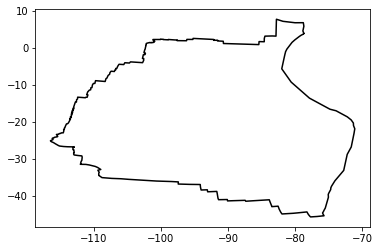

In [7]:
#Get some details about the shapefile. Plot one of the polygons.
#Let us find the areas of each of the polygons in the shapefile.
print(recs[10])

polygonShape=shapes[10].points
poly=np.array(polygonShape)

In [8]:
#Implement a function to calcualte the area of a polygon.
# Area of Polygon using Shoelace formula
# http://en.wikipedia.org/wiki/Shoelace_formula
def PolygonArea(nshp):
    start_time = time.time()
    polygonShape=shapes[nshp].points
    corners=np.array(polygonShape)
    n = len(corners) # of corners
    
    #Area calculation using Shoelace forula
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    
    endtime=time.time() - start_time
    print("Process {} Finished in {:0.4f}s. \n".format(nshp,endtime))
    return(area)

In [9]:
#Run the function for each polygon/plate in the shapefile:
start_time = time.time()
Areas1=[]
for i in polygons:
    Areas1.append(PolygonArea(i))

print("Final Runtime", time.time() - start_time)

Process 0 Finished in 0.0010s. 

Process 1 Finished in 0.0020s. 

Process 2 Finished in 0.0000s. 

Process 3 Finished in 0.0010s. 

Process 4 Finished in 0.0000s. 

Process 5 Finished in 0.0000s. 

Process 6 Finished in 0.0020s. 

Process 7 Finished in 0.0010s. 

Process 8 Finished in 0.0000s. 

Process 9 Finished in 0.0000s. 

Process 10 Finished in 0.0010s. 

Process 11 Finished in 0.0000s. 

Process 12 Finished in 0.0010s. 

Process 13 Finished in 0.0010s. 

Process 14 Finished in 0.0000s. 

Process 15 Finished in 0.0010s. 

Process 16 Finished in 0.0000s. 

Process 17 Finished in 0.0000s. 

Process 18 Finished in 0.0000s. 

Process 19 Finished in 0.0000s. 

Process 20 Finished in 0.0000s. 

Process 21 Finished in 0.0000s. 

Process 22 Finished in 0.0000s. 

Process 23 Finished in 0.0010s. 

Process 24 Finished in 0.0000s. 

Process 25 Finished in 0.0000s. 

Process 26 Finished in 0.0000s. 

Process 27 Finished in 0.0000s. 

Process 28 Finished in 0.0000s. 

Process 29 Finished in 0

In [ ]:
#Run it again, but this time, use the multiprocessing capabilities
start_time = time.time()
with multiprocessing.Pool() as pool:
    Areas2 = pool.map(PolygonArea,polygons)

print("Final Runtime", time.time() - start_time)

In [ ]:
#Run it immediately again. How does the timing compare?
start_time = time.time()
with multiprocessing.Pool() as pool:
    Areas2 = pool.map(PolygonArea,polygons)

print("Final Runtime", time.time() - start_time)

Is there any speed up? What could explain the timings.

<div class="challenge">

### Challenge.

- The *pyshp/shapefile* library contains the function ```signed_area``` which can calculate the area of a polygon. Replace the calculation of ***area*** using the *shoelace* formula in the ```PolygonArea``` function with the ```signed_area``` method:
    
```python
area=shapefile.signed_area(corners)
```

- How does this change the timings of your speed tests?
    
<details>
<summary>Solution</summary>

    
```python
def PolygonArea(nshp):
    start_time = time.time()
    
    area=shapefile.signed_area(corners)
    
    endtime=time.time() - start_time
    print("Process {} Finished in {:0.4f}s. \n".format(nshp,endtime))
    return(area)
```
   
```python
#Test the serial version
start_time = time.time()
Areas1=[]
for i in polygons:
    Areas1.append(PolygonArea(i))

print("Final serial time", time.time() - start_time)
    
#Test the multiprocessing parallel version
start_time = time.time()
with multiprocessing.Pool() as pool:
    Areas2 = pool.map(PolygonArea,polygons)

print("Final multiprocessing time", time.time() - start_time)
```
    
There is generally a sweet spot in how many processes you create to optimise the run time. A large number of python processes is generally not advisable, as it involves a large fixed cost in setting up many python interpreters and its supporting infrastructure. Play around with different numbers of processes in the pool(processes) statement to see how the runtime varies. Also, well developed libraries often have nicely optimised algorithms, you may not have to reinvent the wheel (Haha at this Python pun).
    
</details>
</div>

## Useful links

[https://realpython.com/python-concurrency/](https://realpython.com/python-concurrency/)

[https://docs.python.org/3/library/multiprocessing.html](https://docs.python.org/3/library/multiprocessing.html)

[https://www.backblaze.com/blog/whats-the-diff-programs-processes-and-threads/](https://www.backblaze.com/blog/whats-the-diff-programs-processes-and-threads/)

[https://pawseysc.github.io/training.html](https://pawseysc.github.io/training.html)


## MPI: Message Passing Interface
MPI is a standardized and portable message-passing system designed to function on a wide variety of parallel computers.
The standard defines the syntax and semantics of a core of library routines useful to a wide range of users writing portable message-passing programs in C, C++, and Fortran. There are several well-tested and efficient implementations of MPI, many of which are open-source or in the public domain.

MPI for Python, found in [mpi4py](https://mpi4py.readthedocs.io/en/stable/index.html), provides bindings of the MPI standard for the Python programming language, allowing any Python program to exploit multiple processors. This simple code demonstrates the collection of resources and how code is run on different processes:

In [ ]:
#Run with:
#mpiexec -np 4 python mpi.py

from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print("I am rank %d in group of %d processes." % (rank, size))

<div class="keypoints">  
### keypoints

- "Understand there are different ways to accelerate"
- "The best method depends on your algorithms, code and data"
- "load multiprocessing library to execute a function in a parallel manner"
</div>